Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. 

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
# matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
# matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [16]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [17]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
Row ID           2121 non-null int64
Order ID         2121 non-null object
Order Date       2121 non-null datetime64[ns]
Ship Date        2121 non-null datetime64[ns]
Ship Mode        2121 non-null object
Customer ID      2121 non-null object
Customer Name    2121 non-null object
Segment          2121 non-null object
Country          2121 non-null object
City             2121 non-null object
State            2121 non-null object
Postal Code      2121 non-null int64
Region           2121 non-null object
Product ID       2121 non-null object
Category         2121 non-null object
Sub-Category     2121 non-null object
Product Name     2121 non-null object
Sales            2121 non-null float64
Quantity         2121 non-null int64
Discount         2121 non-null float64
Profit           2121 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(13)
memory usage: 364.5

There are 4 years of furniture sales data

In [18]:
furniture['Order Date'].describe()

count                    2121
unique                    889
top       2016-09-05 00:00:00
freq                       10
first     2014-01-06 00:00:00
last      2017-12-30 00:00:00
Name: Order Date, dtype: object

As we can see first date is `2014-01-06` and last date is `2017-12-30`

## Data Preprocessing

This step includes removing columns we do not need, check missing values.

In [19]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 
        'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

Aggregating sales value by date

In [20]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [21]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with Time Series Data

In [22]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [27]:
furniture['Sales'].head()

Order Date
2014-01-06    2573.820
2014-01-07      76.728
2014-01-10      51.940
2014-01-11       9.940
2014-01-13     879.939
Name: Sales, dtype: float64

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [23]:
y = furniture['Sales'].resample('MS').mean()

In [24]:
y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

Let's take a look at 2015 data

In [29]:
y['2015']

Order Date
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

## Visualizing Furniture Sales Time Series Data

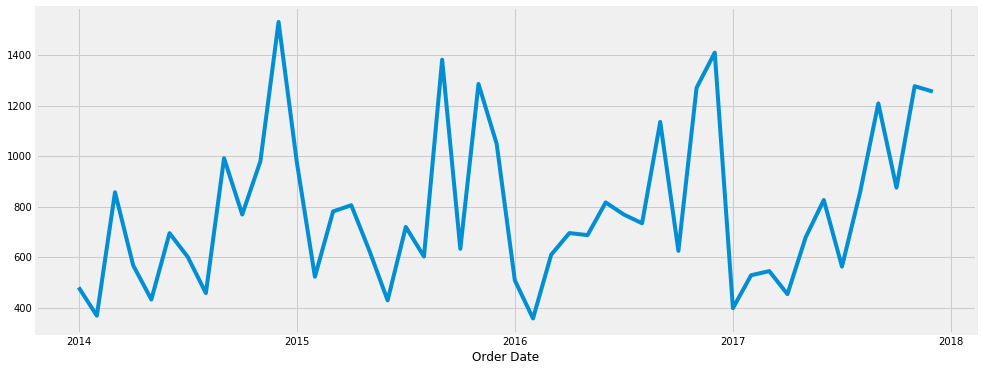

In [30]:
y.plot(figsize=(15, 6))
plt.show()

Distinguishable patterns:
 - The time-series has `seasonality pattern`, such as sales are always low at the beginning of the year and high at the end of the year.
 - There is always an `upward trend` within any single year with a couple of low months in the mid of the year.

Looking at time-series decomposition that allows us to decompose our time series into three distinct components: 
 - trend 
 - seasonality
 - noise

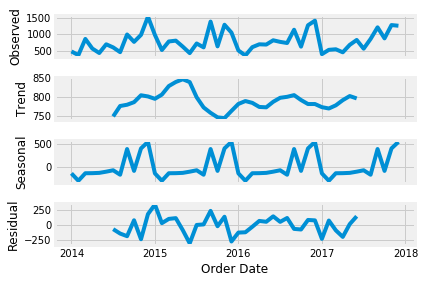

In [32]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.